# Introductory Numerical Methods for Simulating Batch Reactors
This notebook comprises the tutorials and exercises we will use for this lecture.

## Preliminary Code
The cell below defines helper functions to assist with the exercises. Please run this cell be before proceeding below to the exercises.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import fsolve

def plot_solution(ts, *ys, labels = (), marker_size = 3):
    if len(labels) == 0:
        labels = ("y" + str(i) + "(t)" for i in range(1, len(ys)+1))
    f = plt.figure()
    plt.plot(ts, ys[0], marker = 'o', markersize = marker_size, label = labels[0])
    plt.xlabel("time (t)")
    for i in range(1, len(ys)):
        plt.plot(ts, ys[i], marker = 'o', markersize = marker_size, label = labels[i])
    plt.legend(loc='best')
    # return f

## Tutorial 1: Simple ODE Simulation via Explicit Euler
Solve the following ODE:
$$\begin{gathered}
\frac{d y(t)}{dt} = e^{-t} \\
y(0) = -1
\end{gathered}$$
for $t \in [0, 1]$ using $\Delta t=0.1$. Plot your result against the analytical solution (you also need to determine this).

Recall that the update rule for explicit Euler is:
$$\tilde{y}(t_{k+1}) = \tilde{y}(t_k) + f(y(t_k), t_k) \Delta t$$

Now that let's compute the approximate solution using Euler's method. 

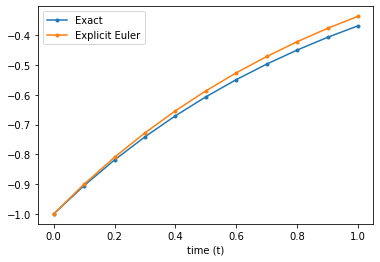

In [8]:
# Define parameters
y0 = -1
dt = 0.1 # TODO try changing this
ts = np.arange(0, 1.0001, dt)
num_steps = len(ts) - 1

# Evaluate the analytical function for each t in ts
y = -np.exp(-ts)

# Define storage vector for y(t)
y_euler = np.zeros(len(ts))

# Fill in y_euler using explicit Euler
y_euler[0] = y0
for k in range(num_steps):
    y_euler[k + 1] = y_euler[k] + np.exp(-ts[k]) * dt

# Plot the results
plot_solution(ts, y, y_euler, labels = ("Exact", "Explicit Euler"))

## Tutorial 2: Simulate Coupled ODEs
Simulate the following system of ODEs:
$$\begin{gathered}
\frac{d y_1(t)}{dt} = -5y_1(t) + 5y_2(t) \\
\frac{d y_2(t)}{dt} = 14y_1(t) - 2y_2(t) \\
y_1(0)=y_2(0)=1 
\end{gathered}$$
for $t \in [0, 1]$ with $\Delta t = 0.1$. 

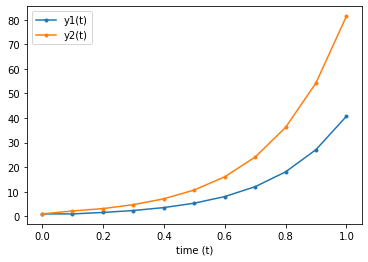

In [28]:
# Define parameters
y0 = np.ones(2)
dt = 0.1
ts = np.arange(0, 1.0001, dt)
num_steps = len(ts) - 1

# Define storage vector for y(t) --> index as y[k, i]
y_euler = np.zeros((len(ts), 2))

# Approximate y(t) using explicit euler and fill in the storage vector
y_euler[0, :] = y0
for k in range(num_steps):
    fk = np.array([-5 * y_euler[k, 0] + 5 * y_euler[k, 1], 14 * y_euler[k, 0] - 2 * y_euler[k, 1]])
    y_euler[k+1, :] = y_euler[k, :] + fk * dt

# Plot the results
plot_solution(ts, y_euler[:, 0],  y_euler[:, 1], labels = ("y1(t)", "y2(t)"))

## Example 1: Stability of Explicit Euler
Simulate the following:
$$\begin{gathered}
\frac{d y(t)}{dt} = -20y(t) \\
y(0) = 1
\end{gathered}$$
for $t \in [0, 1]$ with $\Delta t = 0.1$. Let's compare with the analytical solution as well.

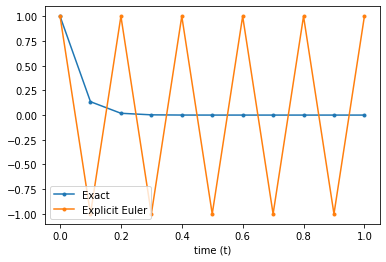

In [26]:
# Define parameters
y0 = 1
dt = 0.1
ts = np.arange(0, 1.0001, dt)
num_steps = len(ts) - 1

# Define storage vectors for y(t)
y_euler = np.zeros(len(ts))

# Define the analytical solution of y(t) for each t in ts
y = np.exp(-20 * ts)

# Do explicit euler and fill y_euler
y_euler[0] = y0
for k in range(num_steps):
    y_euler[k + 1] = y_euler[k] + -20 * y_euler[k] * dt

# Plot the solution 
plot_solution(ts, y, y_euler, labels = ("Exact", "Explicit Euler"))

## Exercise 1: Simulate Reaction Network in Batch Reactor
Simulate the response of the reaction system:
$$\begin{gathered}
\text{A} \rightleftharpoons \text{B} \\
\text{A} \rightleftharpoons \text{C}
\end{gathered}$$
for $t \in [0, 1]$ using implicit Euler. The ODEs are given by:
$$\begin{aligned}
&\frac{d \textbf{c}(t)}{dt} = \gamma \textbf{r}(\textbf{c}, t) \\
&\textbf{c}(0) = c_{i, 0}
\end{aligned}$$
where we have:
$$\textbf{r}(\textbf{c}, t) = \textbf{k}^T(t)\textbf{c}(t)$$
omitting $\beta$ since $\beta=1$ and we have:
$$k_{ij}(t) = A_{ij} \exp\Bigg(\frac{-E_{a,ij}}{RT(t)}\Bigg)$$
The needed parameters are given below.

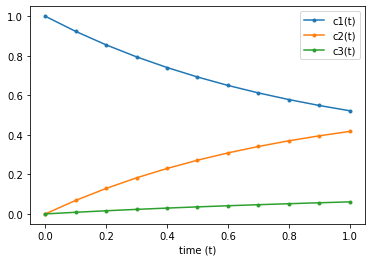

In [29]:
# Define the parameters
R = 1.987
A = np.array([[3.6362e6, 190.6879], [-2.5212e16, 0], [0, -8.7409e24]])
Ea = np.array([[10000., 5000.], [25000., 0], [0., 40000.]])
gamma = np.array([[-1, -1], [1, 0], [0, 1]])
c0 = np.array([1., 0., 0.])
dt = 0.1 # TODO change value here
ts = np.arange(0, 1.0001, dt)
num_steps = len(ts) - 1
Ts = np.ones(len(ts)) * 325.
Ts[Ts < 0.5] = 333

# Define collection array c_euler
c_euler = np.zeros((len(ts), 3)) # time by cs

# Implement explicit Euler and fill c
c_euler[0, :] = c0
for k in range(num_steps):
    ks = A * np.exp(-Ea / R / Ts[k])
    rate = np.dot(ks.T, c_euler[k, :]) # β is always 1 and is unnecessary
    c_euler[k + 1, :] = c_euler[k, :] + np.dot(gamma, rate) * dt

#  Plot the solution
plot_solution(ts, c_euler[:, 0], c_euler[:, 1], c_euler[:, 2], labels = ("c1(t)", "c2(t)", "c3(t)"))